## Compare transports between control and GPC008

I am using some of Adele's scripts to calculate the transport in sigma 1 coordinates over the 1000m isobath. The scripts are located at `/home/156/cy8964/x77/Analysis/cross_slope_transports`. These are run each month and the output is in `/g/data/x77/cy8964/Post_Process/access-om2/##EXPT##` in monthly files.

So far have only run the GPC008 runs (five years worth)


In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
import cmocean as cm


In [2]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34531,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:45191,Total threads: 2
Dashboard: /proxy/42623/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:37263,


### Make database

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# salterature of meltwater at the freezing point calculated with the in situ salinity:
Tf_insituS = 'accessom2-GPC004'
# temperature of meltwater at the freezing point calculated with the 0 salinity:
Tf_zeroS = 'accessom2-GPC005'
# temperature of meltwater equal to the minimum of the above two temperatures:
Tf_min = 'accessom2-GPC006'
Tf_min_bg03 = 'accessom2-GPC007' # Idem as GPC008 but vert dist as in BG03 (2 years)
# temperature of meltwater equal to  min( Tfreezing(s=0),Tinsitu)
Tf_min_s0 = 'accessom2-GPC008'


In [ ]:
# build database for basal melt experiments:
session_name = '/g/data/x77/cy8964/databases/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC004/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC005/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC006/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC007/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC008/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC013/'
           ]
cc.database.build_index(dir_list,basal_melt_session)


Indexing experiment: accessom2-GPC004
Indexing experiment: accessom2-GPC005
Indexing experiment: accessom2-GPC006
Indexing experiment: accessom2-GPC007
Indexing experiment: accessom2-GPC008
Indexing experiment: accessom2-GPC013


100%|██████████| 432/432 [01:54<00:00,  3.77it/s]


In [ ]:
cc.querying.get_ncfiles(basal_melt_session, 'accessom2-GPC013')

In [8]:
cc.querying.get_variables(basal_melt_session, experiment='accessom2-GPC013', frequency='1 monthly')


,name,long_name,units,frequency,ncfile,cell_methods,# ncfiles,time_start,time_end
0,ANGLE,angle grid makes with latitude line on U grid,radians,1 monthly,output1013/ice/OUTPUT/iceh.2152-12.nc,None,36,2150-01-01 00:00:00,2153-01-01 00:00:00
1,ANGLET,angle grid makes with latitude line on T grid,radians,1 monthly,output1013/ice/OUTPUT/iceh.2152-12.nc,None,36,2150-01-01 00:00:00,2153-01-01 00:00:00
2,HTE,T cell width on East side,m,1 monthly,output1013/ice/OUTPUT/iceh.2152-12.nc,None,36,2150-01-01 00:00:00,2153-01-01 00:00:00
3,HTN,T cell width on North side,m,1 monthly,output1013/ice/OUTPUT/iceh.2152-12.nc,None,36,2150-01-01 00:00:00,2153-01-01 00:00:00
4,NCAT,category maximum thickness,m,1 monthly,output1013/ice/OUTPUT/iceh.2152-12.nc,None,36,2150-01-01 00:00:00,2153-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...
169,xt_ocean_sub01,tcell longitude,degrees_E,1 monthly,output1013/ocean/rregionocean_monthly_2d_basal.nc,None,18,2150-01-01 00:00:00,2153-01-01 00:00:00
170,xu_ocean,ucell longitude,degrees_E,1 monthly,output1013/ocean/ocean.nc,None,36,2150-01-01 00:00:00,2153-01-01 00:00:00
171,yt_ocean,tcell latitude,degrees_N,1 monthly,output1013/ocean/ocean_monthly_3d_basal.nc,None,54,2150-01-01 00:00:00,2153-01-01 00:00:00
172,yt_ocean_sub01,tcell latitude,degrees_N,1 monthly,output1013/ocean/rregionocean_monthly_2d_basal.nc,None,18,2150-01-01 00:00:00,2153-01-01 00:00:00


### First plot contour

In [5]:
### Load Adele's isobath contour
isobath_depth = 1000
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']

In [6]:
lat_range = slice(-90,-59)

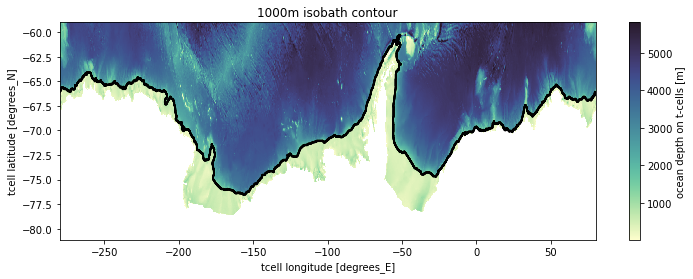

In [7]:
ht = cc.querying.getvar(control, 'ht',master_session, n=1, ncfile = 'ocean_grid.nc')
ht = ht.sel(yt_ocean=lat_range)
yt_ocean = cc.querying.getvar(control, 'yt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
xt_ocean = cc.querying.getvar(control, 'xt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)


fig, axes = plt.subplots(figsize = (12,4))
ht.plot(ax = axes, cmap = cm.cm.deep)
axes.contour(xt_ocean.values, yt_ocean.values,np.abs(mask_x_transport)+np.abs(mask_y_transport),colors = 'k')
axes.set_title('1000m isobath contour')
#plt.savefig('contour.png', dpi = 300)

### Plot control transports

In [8]:
## load control transports from Adele's easterlies folder

test = xr.open_mfdataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc').vol_trans_across_contour_binned
vol_trans_across_contour = xr.zeros_like(test)
count_days = 0
# load five year (5 years x 12 months)
for j in np.arange(2150,2155):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour = vol_trans_across_contour + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour = vol_trans_across_contour/count_days
vol_trans_across_contour

<xarray.DataArray (isopycnal_bins: 132, contour_index: 6002)>
dask.array<truediv, shape=(132, 6002), dtype=float64, chunksize=(132, 6002), chunktype=numpy.ndarray>
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 1.0 27.0 27.1 ... 32.78 32.79 40.0
  * contour_index   (contour_index) int64 1 2 3 4 5 ... 5998 5999 6000 6001 6002

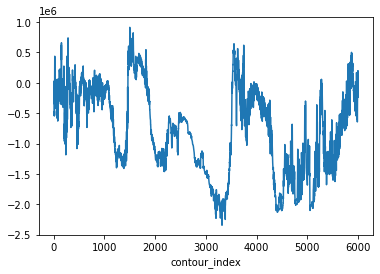

In [9]:
vol_trans_across_contour.sum('isopycnal_bins').cumsum('contour_index').plot()

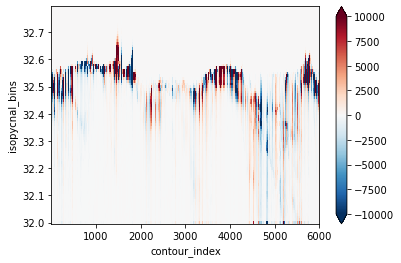

In [10]:
vol_trans_across_contour.sel(isopycnal_bins = slice(32,34)).plot(vmax = 10000)

Text(0.5, 1.0, 'Off-shore transport, integrated cumulatively \nfrom densest to lightest')

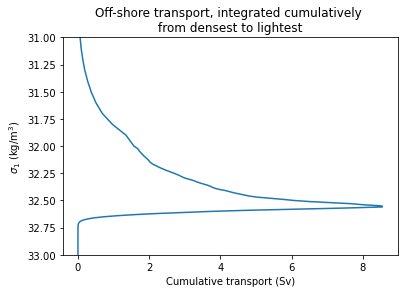

In [11]:
a = (vol_trans_across_contour/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins')
plt.ylim(33,31)
plt.xlabel('Cumulative transport (Sv)')
plt.ylabel('$\sigma_1$ (kg/m$^3$)')
plt.title('Off-shore transport, integrated cumulatively \nfrom densest to lightest')


### Make nicer y axis than `contour_index` by loading in lon/lat/distance of contour

according to cosima recipes https://nbviewer.org/github/claireyung/cosima-recipes/blob/master/DocumentedExamples/Cross-contour_transport.ipynb

In [21]:
expt = control
session = master_session

In [22]:
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(expt,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)
xu_ocean = cc.querying.getvar(expt,'xu_ocean',session,n=1)

# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for vhrho, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for uhrho, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.

mask_x_transport = xr.DataArray(mask_x_transport, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])

# ### Stack contour data into 1D

# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean
# don't need the multi-index anymore, replace with contour count
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array



In [68]:
# ## save distance - this takes time

# dxu = cc.querying.getvar(expt,'dxu',session,ncfile = 'ocean_grid.nc',n=1)
# dxu = dxu.sel(yu_ocean = lat_range)
# dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
# dyt = dyt.sel(yt_ocean = lat_range)
# num_points = len(lat_along_contour)
# lat_t = cc.querying.getvar(expt,'geolat_t',session,ncfile = 'ocean_grid.nc',n=1)
# lat_t = lat_t.sel(yt_ocean = lat_range)
# lon_t = cc.querying.getvar(expt,'geolon_t',session,ncfile = 'ocean_grid.nc',n=1)
# lon_t = lon_t.sel(yt_ocean = lat_range)

# # if there is a bend in the contour, add the distance using length of diagonal, not sum of
# # 2 edges, to be more representative.    
# distance_along_contour = np.zeros((num_points))
# x_indices = np.sort(mask_x_transport_numbered.values[mask_x_transport_numbered.values>0])
# y_indices = np.sort(mask_y_transport_numbered.values[mask_y_transport_numbered.values>0])
# skip = False
# for count in range(1,num_points):
#     if skip == True:
#         skip = False
#         continue
#     if count in y_indices:
#         if count + 1 in y_indices:
#             # note dxu and dyt do no vary in x:
#             jj = np.where(mask_y_transport_numbered==count)[0]
#             distance_along_contour[count-1] = (dxu[jj,990])[0]
#         else:
#             jj0 = np.where(mask_y_transport_numbered==count)[0]
#             jj1 = np.where(mask_x_transport_numbered==count+1)[0]
#             diagonal_distance = 0.5*np.sqrt((dxu[jj0,990])[0]**2+\
#                 (dyt[jj1,990])[0]**2)
#             distance_along_contour[count-1] = diagonal_distance
#             distance_along_contour[count] = diagonal_distance
#             # skip to next count:
#             skip = True
#     # count in x_indices:
#     else:
#         if count + 1 in x_indices:
#             jj = np.where(mask_x_transport_numbered==count)[0]
#             distance_along_contour[count-1] = (dyt[jj,990])[0]
#         else:
#             jj0 = np.where(mask_x_transport_numbered==count)[0]
#             jj1 = np.where(mask_y_transport_numbered==count+1)[0]
#             diagonal_distance = 0.5*np.sqrt((dyt[jj0,990])[0]**2+\
#                 (dxu[jj1,990])[0]**2)
#             distance_along_contour[count-1] = diagonal_distance
#             distance_along_contour[count] = diagonal_distance
#             # skip to next count:
#             skip = True
# # fix last value:
# if distance_along_contour[-1] == 0:
#     count = count + 1
#     if count in y_indices:
#         jj = np.where(mask_y_transport_numbered==count)[0]
#         distance_along_contour[-1] = (dxu[jj,990])[0]
#     else:
#         jj = np.where(mask_x_transport_numbered==count)[0]
#         distance_along_contour[-1] = (dyt[jj,990])[0]

# # units are 10^3 km:
# distance_along_contour = np.cumsum(distance_along_contour)/1e3/1e3 
# #save_dir = '/g/data/x77/cy8964/Post_Process/access-om2/'
# #ds_latlondist = xr.Dataset({'distance_along_contour': distance_along_contour})
# #ds_latlondist.to_netcdf(save_dir+'1000m_isobath_contour_distance.nc')

In [23]:
distance_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/access-om2/1000m_isobath_contour_distance.nc').distance_along_contour

In [24]:
distance_indices = np.zeros(8)
for i in np.arange(100,len(lon_along_contour.values)):
    if (distance_indices[1]==0):
        if (lon_along_contour.values[i]>-240):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.values[i]>-180):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.values[i]>-120):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if lon_along_contour.values[i]>-60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.values[i]>0):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.values[i]>60):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
distance_indices[7] = len(lon_along_contour.contour_index.values)-1


Text(0.5, 0, 'Longitude coordinates along contour')

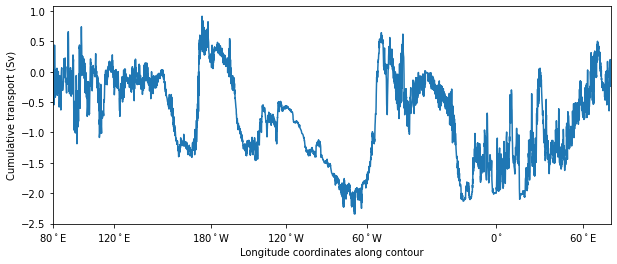

In [25]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour.sum('isopycnal_bins').cumsum('contour_index')))
axes.set_ylabel('Cumulative transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')


### Load GPC008

In [26]:
## load control transports from Adele's easterlies folder

test = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC008/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc').vol_trans_across_contour_binned
vol_trans_across_contour_GPC008 = xr.zeros_like(test)
count_days = 0
# load five year (5 years x 12 months)
for j in np.arange(2150,2155):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC008/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC008 = vol_trans_across_contour_GPC008 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC008 = vol_trans_across_contour_GPC008/count_days
vol_trans_across_contour_GPC008

<xarray.DataArray (isopycnal_bins: 132, contour_index: 6002)>
dask.array<truediv, shape=(132, 6002), dtype=float64, chunksize=(132, 6002), chunktype=numpy.ndarray>
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 1.0 27.0 27.1 ... 32.78 32.79 40.0
  * contour_index   (contour_index) int64 1 2 3 4 5 ... 5998 5999 6000 6001 6002

In [27]:
## load individual years
test = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC008/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc').vol_trans_across_contour_binned

vol_trans_across_contour_GPC008_yr1 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2150,2151):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC008/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC008_yr1 = vol_trans_across_contour_GPC008_yr1 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC008_yr1 = vol_trans_across_contour_GPC008_yr1/count_days

vol_trans_across_contour_GPC008_yr2 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2151,2152):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC008/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC008_yr2 = vol_trans_across_contour_GPC008_yr2 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC008_yr2 = vol_trans_across_contour_GPC008_yr2/count_days

vol_trans_across_contour_GPC008_yr3 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2152,2153):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC008/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC008_yr3 = vol_trans_across_contour_GPC008_yr3 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC008_yr3 = vol_trans_across_contour_GPC008_yr3/count_days

vol_trans_across_contour_GPC008_yr4 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2153,2154):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC008/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC008_yr4 = vol_trans_across_contour_GPC008_yr4 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC008_yr4 = vol_trans_across_contour_GPC008_yr4/count_days

vol_trans_across_contour_GPC008_yr5 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2154,2155):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC008/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC008_yr5 = vol_trans_across_contour_GPC008_yr5 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC008_yr5 = vol_trans_across_contour_GPC008_yr5/count_days


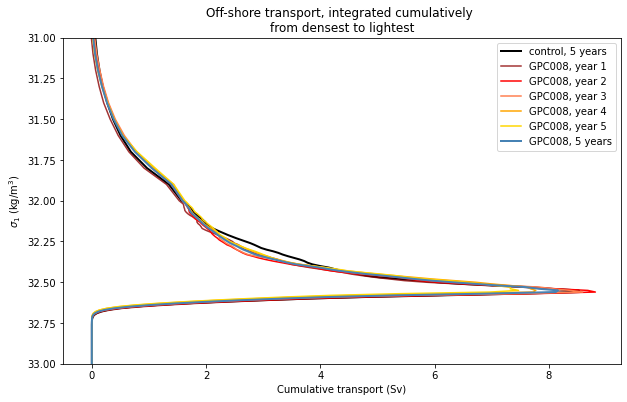

In [14]:
fig = plt.figure(figsize = (10,6))
a = (vol_trans_across_contour/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', label = 'control, 5 years',color = 'k', linewidth = 2)
# plot individual years in grey
b = (vol_trans_across_contour_GPC008_yr1/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'darkred',alpha = 0.8, label = 'GPC008, year 1')
b = (vol_trans_across_contour_GPC008_yr2/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'red',alpha = 1, label = 'GPC008, year 2')
b = (vol_trans_across_contour_GPC008_yr3/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'coral',alpha = 1, label = 'GPC008, year 3')
b = (vol_trans_across_contour_GPC008_yr4/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'orange',alpha = 1, label = 'GPC008, year 4')
b = (vol_trans_across_contour_GPC008_yr5/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'gold',alpha = 1, label = 'GPC008, year 5')
# plot mean in blue
b = (vol_trans_across_contour_GPC008/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', label = 'GPC008, 5 years',color = 'steelblue', linewidth = 2)

plt.ylim(33,31)
plt.xlabel('Cumulative transport (Sv)')
plt.ylabel('$\sigma_1$ (kg/m$^3$)')
plt.title('Off-shore transport, integrated cumulatively \nfrom densest to lightest')
plt.legend()
plt.savefig('offshore_transport_sum.png',dpi = 300)

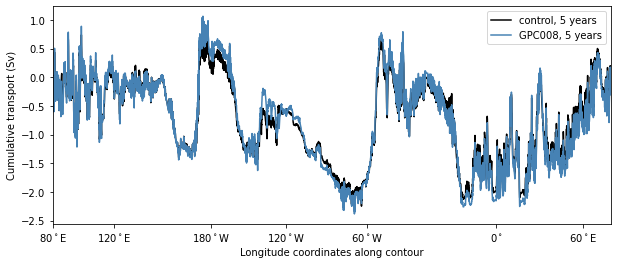

In [28]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour.sum('isopycnal_bins').cumsum('contour_index')),label = 'control, 5 years', color = 'k')
axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour_GPC008.sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC008, 5 years',color = 'steelblue')
axes.set_ylabel('Cumulative transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')

plt.legend()
plt.savefig('transport_cumsum.png',dpi = 300)

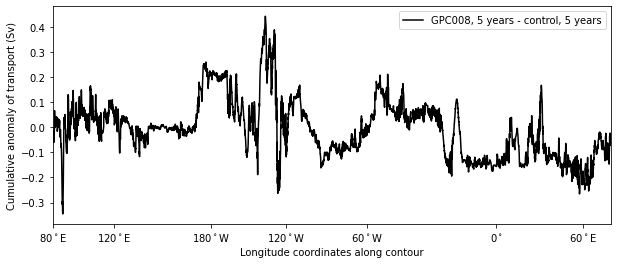

In [24]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*(vol_trans_across_contour_GPC008-vol_trans_across_contour).sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC008, 5 years - control, 5 years', color = 'k')
axes.set_ylabel('Cumulative anomaly of transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')
plt.legend()

Indicates more cross-contour transport (northward flow) near Ross Sea (180W region, cumulative integral of anomaly is increasing) than control, and less in Amundsen (120W region where cumulative integral of anomaly is on average decreasing) - agrees with more DSW transport in Ross and something different happening in Amundsen.

Plotting transports without cumulatively integrating them is a mess due to eddies:

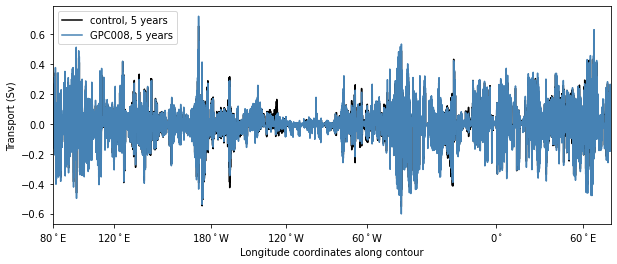

In [23]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour.sum('isopycnal_bins')),label = 'control, 5 years', color = 'k')
axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour_GPC008.sum('isopycnal_bins')),label = 'GPC008, 5 years',color = 'steelblue')
axes.set_ylabel('Transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')
plt.legend()

Anomaly of transport in each bin:

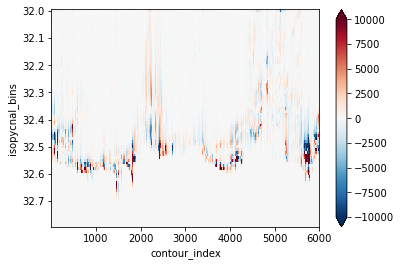

In [34]:
(vol_trans_across_contour_GPC008-vol_trans_across_contour).sel(isopycnal_bins = slice(32,34)).plot(vmax = 10000, yincrease = False)

Main change in lower densities is in Amundsen with more northward transport?

### Plot time series of maximum depth and density over time

In [9]:
## load transports as a time series

test = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC008/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc').vol_trans_across_contour_binned
vol_trans_across_contour_GPC008_t = xr.zeros_like(test)
vol_trans_across_contour_GPC008_t  = vol_trans_across_contour_GPC008_t.expand_dims({"time":np.arange(60)})

count_days = 0
# load five year (5 years x 12 months)
for j in np.arange(2150,2155):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC008/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        it.load()
        vol_trans_across_contour_GPC008_t[i+12*(j-2150)-1,:,:] = it.vol_trans_across_contour_binned #*it.ndays
        count_days = count_days + it.ndays.values
        print(i+12*(j-2150)-1)
# divide by total of number of days in each month for correct annual average    
#vol_trans_across_contour_GPC008 = vol_trans_across_contour_GPC008/count_days
#vol_trans_across_contour_GPC008

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


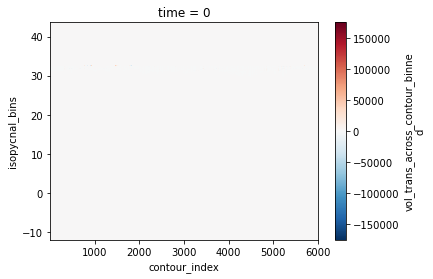

In [10]:
vol_trans_across_contour_GPC008_t.isel(time = 0).plot()

Text(0.5, 0, 'Time (months)')

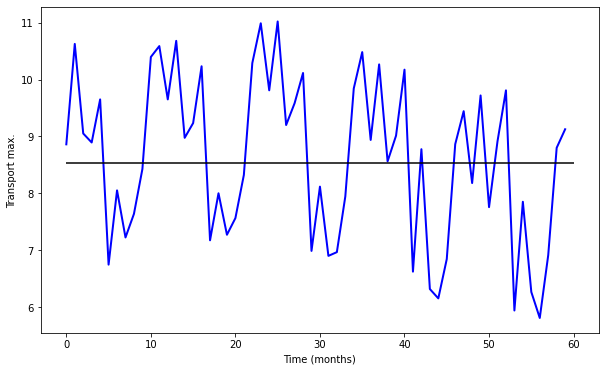

In [14]:
fig = plt.figure(figsize = (10,6))
a = (vol_trans_across_contour_GPC008_t/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).max('isopycnal_bins').plot(label = 'GPC008, monthly means',color = 'b', linewidth = 2)
c = (vol_trans_across_contour/1e6).sum('contour_index')
b = (c.sum('isopycnal_bins') -c.cumsum('isopycnal_bins')).max('isopycnal_bins')#plot(label = 'GPC008',color = 'b', linewidth = 2)
plt.hlines(b, 0,60, color = 'k', label = 'control, 5 year mean')

plt.ylabel('Transport max. (Sv)')
plt.xlabel('Time (months)')
plt.title('Transport maximum over time')
plt.legend()

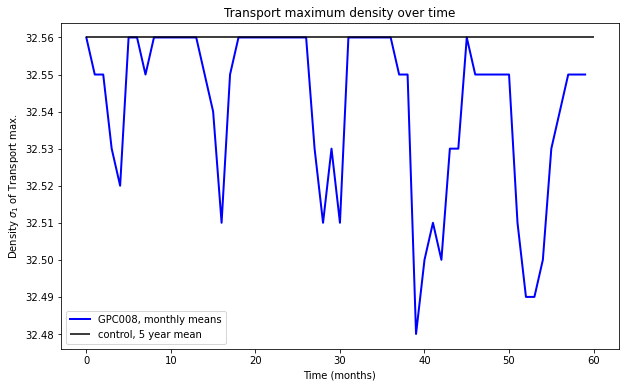

In [20]:
fig = plt.figure(figsize = (10,6))
a = (vol_trans_across_contour_GPC008_t/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).idxmax('isopycnal_bins').plot(label = 'GPC008, monthly means',color = 'b', linewidth = 2)
c = (vol_trans_across_contour/1e6).sum('contour_index')
b = (c.sum('isopycnal_bins') -c.cumsum('isopycnal_bins')).idxmax('isopycnal_bins')#plot(label = 'GPC008',color = 'b', linewidth = 2)
plt.hlines(b, 0,60, color = 'k', label = 'control, 5 year mean')

plt.ylabel('Density $\sigma_1$ of Transport max.')
plt.xlabel('Time (months)')
plt.title('Transport maximum density over time')
plt.legend()

### Transport cumulative sums for different density classes


Text(0.5, 1.0, '$\\sigma_1$ > 32.56')

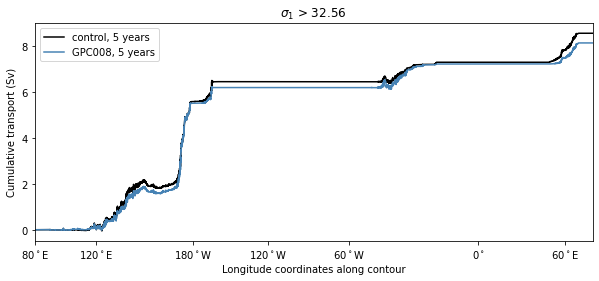

In [29]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour.sel(isopycnal_bins = slice(32.56,40)).sum('isopycnal_bins').cumsum('contour_index')),label = 'control, 5 years', color = 'k')
axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour_GPC008.sel(isopycnal_bins = slice(32.56,40)).sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC008, 5 years',color = 'steelblue')
axes.set_ylabel('Cumulative transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')

plt.legend()
plt.title('$\sigma_1$ > 32.56')

DSW category in Morrison et al. (2020) - DSW decreases.

Text(0.5, 1.0, '32.4 < $\\sigma_1$ < 32.56')

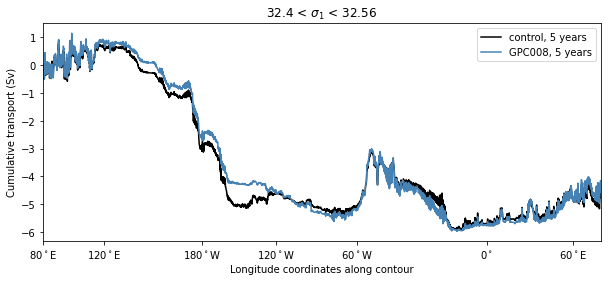

In [30]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour.sel(isopycnal_bins = slice(32.4,32.56)).sum('isopycnal_bins').cumsum('contour_index')),label = 'control, 5 years', color = 'k')
axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour_GPC008.sel(isopycnal_bins = slice(32.4,32.56)).sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC008, 5 years',color = 'steelblue')
axes.set_ylabel('Cumulative transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')

plt.legend()
plt.title('32.4 < $\sigma_1$ < 32.56')

CDW in Morrison et al. - decreases in most regions, increases in Amundsen?

Text(0.5, 1.0, '$\\sigma_1$ < 32.4')

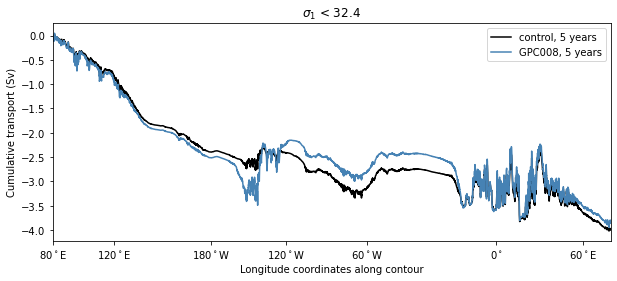

2022-10-20 15:55:13,041 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-10-20 15:55:13,042 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-10-20 15:55:13,043 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-10-20 15:55:13,099 - distributed.nanny - WARNING - Restarting worker
2022-10-20 15:55:13,104 - distributed.nanny - WARNING - Restarting worker
2022-10-20 15:55:13,222 - distributed.nanny - WARNING - Restarting worker
2022-10-20 15:55:13,225 - distributed.nanny - WARNING - Restarting worker
2022-10-20 15:55:13,291 - distributed.nanny - WARNING - Restarting worker
2022-10-20 15:55:13,331 - distributed.nanny - WARNING - Restarting worker
2022-10-20 15:55:13,381 - distributed.nanny - WARNING - Restarting worker
2022-10-20 15:55:13,384 - distributed.nanny - WARNING - Restarting worker
2022-10-20 15:55:13,418 - distributed.nanny - WARNING - Restarting worker
2022-10-20 15:55:13,503 - distributed.nanny - WARNING - Restarting worker

In [31]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour.sel(isopycnal_bins = slice(0,32.4)).sum('isopycnal_bins').cumsum('contour_index')),label = 'control, 5 years', color = 'k')
axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour_GPC008.sel(isopycnal_bins = slice(0, 32.4)).sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC008, 5 years',color = 'steelblue')
axes.set_ylabel('Cumulative transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')

plt.legend()
plt.title('$\sigma_1$ < 32.4')

AASW in Morrison et al. (2020) decreasing in most places, except near peninsula??